In [3]:
import json, os, random
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pycocotools.coco import COCO
from tqdm import tqdm

In [4]:
TARGET_CLASSES = ["person", "car", "bicycle", "dog", "chair"]

DATASET = 'COCO_DATASET'
ANN_FILE = os.path.join(DATASET, 'annotations/instances_subset_mini_train2017.json')
IMG_FILE = os.path.join(DATASET, 'images/train2017')

In [3]:
coco = COCO(ANN_FILE)

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [4]:
cat_ids = coco.getCatIds()
cats = coco.loadCats(cat_ids)

category_map = {}
for c in cats:
    category_map[c["id"]] = c["name"]

image_ids = coco.getImgIds()

In [5]:
print(image_ids)

[98304, 524291, 229391, 131087, 294933, 393243, 458781, 327713, 491556, 229419, 524338, 294968, 65604, 74, 360535, 524382, 557155, 196711, 491628, 109, 458870, 557174, 327804, 327810, 229507, 524420, 262286, 327843, 196773, 426151, 393384, 295097, 524476, 196797, 98494, 164042, 65753, 229603, 196842, 65773, 98560, 164102, 327944, 426254, 491793, 262418, 33044, 557343, 426275, 307, 309, 491831, 459064, 491837, 393542, 459084, 557394, 524627, 524628, 164186, 295263, 359, 262505, 524665, 262531, 65924, 459141, 491910, 557451, 262561, 360869, 131497, 98733, 426418, 436, 65984, 229825, 197057, 164290, 557508, 164292, 459208, 229840, 491991, 557543, 197097, 295410, 492020, 459255, 164348, 295423, 459265, 557586, 531, 98836, 426518, 360991, 66082, 33325, 262718, 581, 197201, 131674, 262747, 33377, 492137, 131696, 295537, 66166, 33405, 641, 393857, 131714, 262786, 492171, 197270, 66217, 524979, 524981, 66230, 524992, 197330, 99041, 197368, 393978, 525058, 790, 459557, 262952, 99112, 66345, 394

## Region Propsals

In [6]:
def compute_iou(a, b):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b

    ix1, iy1 = max(ax1, bx1), max(ay1, by1)
    ix2, iy2 = min(ax2, bx2), min(ay2, by2)

    iw, ih = max(0, ix2 - ix1), max(0, iy2 - iy1)
    inter = iw * ih

    area_a = (ax2 - ax1) * (ay2 - ay1)
    area_b = (bx2 - bx1) * (by2 - by1)
    union = area_a + area_b - inter

    return inter / union if union > 0 else 0

In [7]:
def sliding_win(img, win_w, win_h, stride):
    H, W = img.shape[:2]
    for y in range(0, H - win_h + 1, stride):
        for x in range(0, W - win_w + 1, stride):
            yield x, y, x + win_w, y + win_h

In [ ]:
random.seed(42)
np.random.seed(42)


BASE_SIZES = [96, 128, 192, 256]
CLASS_ASPECT_RATIOS = {
    "person":   [(1, 2)],
    "bicycle":  [(5, 3)],
    "car":      [(4, 3), (16, 9)],
    "dog":      [(1, 1)],
    "chair":    [(1, 1)],
}
STRIDE_RATIO = 0.25

PYRAMID_SCALES = [1.0, 0.75, 0.5]


POS_IOU_TH = 0.6
NEG_IOU_TH = 0.2

MAX_POS_SAMPLE = 50
MAX_POS_CLASS = {
    "person": 10,     # 🔒 strong cap
}

MAX_NEG_SAMPLE = 5

OUT_DIR = "extract_ready"

In [9]:
os.makedirs(OUT_DIR, exist_ok=True)

for c in TARGET_CLASSES + ["background"]:
    os.makedirs(os.path.join(OUT_DIR, c), exist_ok=True)

In [10]:
for img_id in tqdm(image_ids):
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(IMG_FILE, img_info["file_name"])
    img = cv2.imread(img_path)

    if img is None:
        continue

    ann_ids = coco.getAnnIds(imgIds=[img_id], catIds=cat_ids)
    anns = coco.loadAnns(ann_ids)
    if len(anns) == 0:
        continue

    gt_objects = []
    for ann in anns:
        c_name = category_map.get(ann["category_id"])
        if c_name is None:
            continue

        x, y, w, h = ann["bbox"]
        gt_objects.append({
            "bbox": (int(x), int(y), int(x+w), int(y+h)),
            "class" : category_map[ann["category_id"]]
        })

    if not gt_objects:
        continue
    gt_classes = set(obj["class"] for obj in gt_objects)
    p_buffer, n_buffer = [], []
    p_count = {c: 0 for c in TARGET_CLASSES}
    for scale in PYRAMID_SCALES:
        resized = cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
        for base in BASE_SIZES:
            for c_name in gt_classes:
                for ar_w, ar_h in CLASS_ASPECT_RATIOS[c_name]:
                    win_w = int(base * ar_w/ar_h)
                    win_h = int(base)
                    
                    stride = int(min(win_w, win_h) * STRIDE_RATIO)
                    for wx1, wy1, wx2, wy2 in sliding_win(resized, win_w, win_h, stride):
                        crop = resized[wy1:wy2, wx1:wx2]
                        if crop.size == 0:
                            continue
                        max_iou = 0
                        matched = None
                        
                        for obj in gt_objects:
                            gx1, gy1, gx2, gy2 = obj["bbox"]
                            gt_scaled = (int(gx1 * scale), int(gy1 * scale), int(gx2 * scale), int(gy2 * scale))
                            iou = compute_iou((wx1, wy1, wx2, wy2), gt_scaled)
                            
                            if iou > max_iou:
                                max_iou = iou
                                matched = obj["class"]
                        
                        if max_iou >= POS_IOU_TH:
                            class_cap = MAX_POS_CLASS.get(matched, 32)
                            if p_count[matched] >= class_cap:
                                continue

                            p_buffer.append({
                                "crop": crop,
                                "iou": max_iou,
                                "class": matched
                            })
                            p_count[matched] += 1
                            
                        elif max_iou <= NEG_IOU_TH:
                            n_buffer.append({
                                "crop": crop,
                            })
                            
    p_buffer = sorted(p_buffer, key=lambda x: x["iou"], reverse=True)[:MAX_POS_SAMPLE]
    if len(n_buffer) > MAX_NEG_SAMPLE:
        n_buffer = random.sample(n_buffer, MAX_NEG_SAMPLE)
    img_stub = os.path.splitext(img_info["file_name"])[0]
    for sample in p_buffer:
        out_class = sample["class"]
        fname = f"{img_stub}_pos_{random.randint(0, 1e9)}.jpg"
        cv2.imwrite(
            os.path.join(OUT_DIR, out_class, fname),
            sample["crop"]
        )
    for sample in n_buffer:
        fname = f"{img_stub}_neg_{random.randint(0, 1e9)}.jpg"
        cv2.imwrite(
            os.path.join(OUT_DIR, "background", fname),
            sample["crop"]
        )

100%|██████████| 5134/5134 [03:55<00:00, 21.80it/s]


## Feature Extraction

In [11]:
from skimage.feature import hog, local_binary_pattern
from tqdm import tqdm
import os, json

In [12]:
DATASET_DIR = "extract_ready"
OUT_DIR = "features"

LBP_RADIUS = 1
LBP_POINTS = 8 * LBP_RADIUS
LBP_METHOD = "uniform"
LBP_BINS = LBP_POINTS + 2
COLOR_BINS = (8, 8, 8)

TARGET_CLASSES = TARGET_CLASSES + ["background"]
IMG_SIZE = (128, 128)
HOG_PAR = dict(
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block =(2, 2),
    block_norm = "L2-Hys",
    transform_sqrt=True,
    feature_vector=True
)

# os.makedirs(OUT_DIR, exist_ok=True)
X_feats = []
Y_labels = []

In [13]:
def extract_hog(gray):
    hog_vec = hog(gray, **HOG_PAR)
    return hog_vec

def extract_lbp(gray):
    lbp = local_binary_pattern(gray, LBP_POINTS, LBP_RADIUS, method=LBP_METHOD)
    hist, _ = np.histogram(lbp.ravel(), bins=LBP_BINS, range=(0, LBP_BINS))
    hist = hist.astype(np.float32)
    hist = hist/(hist.sum() + 1e-6)
    return hist

def extract_color(img):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([img_hsv], channels=[0, 1, 2], mask=None, histSize=COLOR_BINS, ranges=[0, 180, 0, 256, 0, 256])
    hist = hist.flatten().astype(np.float32)
    hist = hist/(hist.sum() + 1e-6)

    return hist

In [14]:
def extract_feat(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog_feat = extract_hog(gray)
    lbp_feat = extract_lbp(gray)
    clr_feat = extract_color(img)

    feat_vec = np.concatenate([hog_feat, lbp_feat, clr_feat])
    return feat_vec

In [15]:
for c_id, c_name in enumerate(TARGET_CLASSES):
    c_dir = os.path.join(DATASET_DIR, c_name)
    if not os.path.exists(c_dir):
        continue

    print(f"Extracting features for class: {c_name}")
    for f_name in tqdm(os.listdir(c_dir), desc=c_name):
        img_path = os.path.join(c_dir, f_name)
        img = cv2.imread(img_path)

        if img is None:
            continue

        #Extract Features
        img_rs = cv2.resize(img, IMG_SIZE)
        feat_vec = extract_feat(img_rs)
        X_feats.append(feat_vec)
        Y_labels.append(c_id)

X_features = np.array(X_feats, dtype=np.float32)
Y_labels = np.array(Y_labels, dtype=np.int64)

np.savez_compressed(
    os.path.join(OUT_DIR, "fused_features_coco_mini.npz"),
    X = X_features,
    Y = Y_labels
)

Extracting features for class: person


person: 100%|██████████| 3269/3269 [00:53<00:00, 60.80it/s]


Extracting features for class: car


car: 100%|██████████| 2178/2178 [00:34<00:00, 63.26it/s]


Extracting features for class: bicycle


bicycle: 100%|██████████| 5424/5424 [01:24<00:00, 64.48it/s]


Extracting features for class: dog


dog: 100%|██████████| 13624/13624 [03:40<00:00, 61.78it/s]


Extracting features for class: chair


chair: 100%|██████████| 2442/2442 [00:38<00:00, 62.92it/s]


Extracting features for class: background


background: 100%|██████████| 25667/25667 [07:05<00:00, 60.34it/s]


In [16]:
print(X_features.shape)
print(Y_labels.shape)

(52604, 8622)
(52604,)


## Training

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

FEAT_PATH = r"features\fused_features_coco_mini.npz"
CLASS_NAMES = TARGET_CLASSES

data = np.load(FEAT_PATH)
X = data["X"]
y = data["Y"]

print(X.shape)
print(y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape[0])
print(X_test.shape[0])

scaler = StandardScaler(with_mean=False)
X_trains = scaler.fit_transform(X_train)
X_tests = scaler.transform(X_test)

(52604, 8622)
(52604,)
42083
10521


In [6]:
#PCA Dimensionality Reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, svd_solver="full")
X_train_pca = pca.fit_transform(X_trains)
X_test_pca = pca.transform(X_tests)

In [7]:
print("Original dim:", X.shape[1])
print("Reduced dim:", X_train_pca.shape[1])
print("Explained variance:", np.sum(pca.explained_variance_ratio_))

Original dim: 8622
Reduced dim: 2345
Explained variance: 0.95001274


In [16]:
pca_r = PCA(n_components=256, random_state=42, svd_solver='randomized')
X_train_pcar = pca_r.fit_transform(X_trains)
X_test_pcar = pca_r.transform(X_tests)

In [14]:
print("Reduced dim:", X_train_pcar.shape[1])
print("Explained variance:", np.sum(pca_r.explained_variance_ratio_))

Reduced dim: 256
Explained variance: 0.5055742


In [21]:
pca_t = PCA(n_components=0.85, svd_solver='auto')
X_train_pcat = pca_t.fit_transform(X_trains)
X_test_pcat = pca_t.transform(X_tests)

print("Reduced dim:", X_train_pcat.shape[1])
print("Explained variance:", np.sum(pca_t.explained_variance_ratio_))

Reduced dim: 1439
Explained variance: 0.85000694


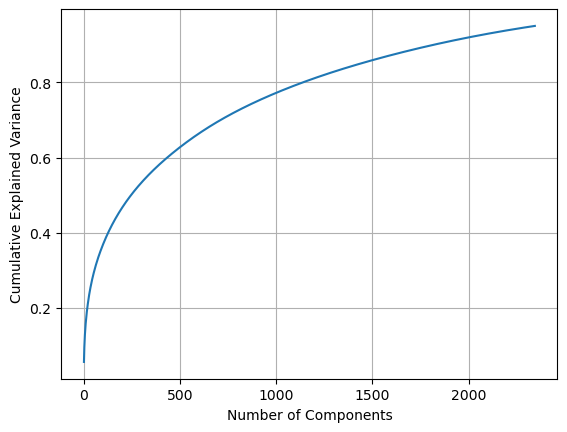

In [8]:
import matplotlib.pyplot as plt

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()


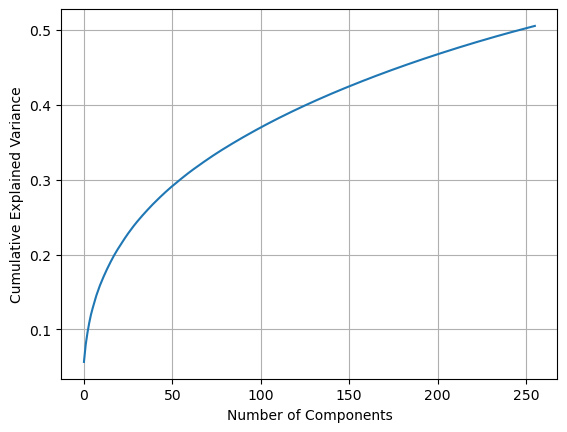

In [17]:
plt.plot(np.cumsum(pca_r.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

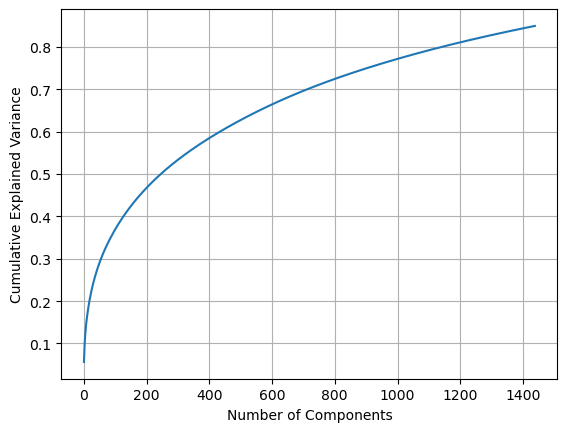

In [22]:
plt.plot(np.cumsum(pca_t.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

In [18]:
svm = LinearSVC(
    C = 0.01,
    class_weight = "balanced",
    max_iter = 5000
)

print("Training Linear SVM (OvR)...")
svm.fit(X_trains, Y_train)

y_pred = svm.predict(X_tests)
print(classification_report(Y_test, y_pred, target_names=CLASS_NAMES, digits=2))

cm = confusion_matrix(Y_test, y_pred)
print(cm)

Training Linear SVM (OvR)...
              precision    recall  f1-score   support

      person       0.44      0.49      0.46       654
         car       0.47      0.55      0.51       436
     bicycle       0.57      0.64      0.61      1085
         dog       0.68      0.73      0.70      2725
       chair       0.36      0.45      0.40       488
  background       0.78      0.69      0.73      5133

    accuracy                           0.66     10521
   macro avg       0.55      0.59      0.57     10521
weighted avg       0.68      0.66      0.67     10521

[[ 320   21   45   54   29  185]
 [  18  238   33   47   13   87]
 [  23   50  695  130   33  154]
 [  61   30  126 1978   76  454]
 [  29   19   21   56  218  145]
 [ 284  146  292  642  231 3538]]


In [19]:
import joblib
import os

MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

joblib.dump(svm, os.path.join(MODEL_DIR, "hog_svm_3f.joblib"))
joblib.dump(scaler, os.path.join(MODEL_DIR, "hog_scaler_3f.joblib"))

['models\\hog_scaler_3f.joblib']

In [ ]:
svm_pca = LinearSVC(
    C = 0.01,
    class_weight = "balanced",
    max_iter = 5000
)

print("Training Linear SVM (OvR)...")
svm_pca.fit(X_train_pca, Y_train)

y_pred = svm_pca.predict(X_test_pca)


In [11]:
print(classification_report(Y_test, y_pred, target_names=CLASS_NAMES, digits=2))

cm = confusion_matrix(Y_test, y_pred)
print(cm)

              precision    recall  f1-score   support

      person       0.43      0.58      0.49       654
         car       0.33      0.55      0.41       436
     bicycle       0.52      0.61      0.56      1085
         dog       0.66      0.63      0.65      2725
       chair       0.27      0.46      0.34       488
  background       0.79      0.64      0.71      5133

    accuracy                           0.62     10521
   macro avg       0.50      0.58      0.53     10521
weighted avg       0.66      0.62      0.63     10521

[[ 379   30   34   33   45  133]
 [  31  241   39   32   27   66]
 [  25   83  664  137   52  124]
 [  93   92  217 1723  154  446]
 [  25   30   39   51  224  119]
 [ 336  262  295  618  326 3296]]


In [10]:
CLASS_NAMES = TARGET_CLASSES + ["background"]

In [19]:
svm_pcar = LinearSVC(
    C = 0.01,
    class_weight = "balanced",
    max_iter = 5000
)

print("Training Linear SVM (OvR)...")
svm_pcar.fit(X_train_pcar, Y_train)

y_pred = svm_pcar.predict(X_test_pcar)
print(classification_report(Y_test, y_pred, target_names=CLASS_NAMES, digits=2))

cm = confusion_matrix(Y_test, y_pred)
print(cm)

Training Linear SVM (OvR)...
              precision    recall  f1-score   support

      person       0.40      0.60      0.48       654
         car       0.30      0.44      0.35       436
     bicycle       0.45      0.60      0.52      1085
         dog       0.64      0.59      0.61      2725
       chair       0.23      0.32      0.27       488
  background       0.77      0.64      0.70      5133

    accuracy                           0.60     10521
   macro avg       0.47      0.53      0.49     10521
weighted avg       0.64      0.60      0.61     10521

[[ 391   32   27   28   31  145]
 [  48  193   47   44   23   81]
 [  34   63  648  167   35  138]
 [ 108  106  312 1608  135  456]
 [  21   38   56   66  154  153]
 [ 375  222  339  608  284 3305]]


In [ ]:
svm_pcat = LinearSVC(
    C = 0.01,
    class_weight = "balanced",
    max_iter = 5000
)

print("Training Linear SVM (OvR)...")
svm_pcat.fit(X_train_pcat, Y_train)


In [24]:
y_pred = svm_pcat.predict(X_test_pcat)
print(classification_report(Y_test, y_pred, target_names=CLASS_NAMES, digits=2))

cm = confusion_matrix(Y_test, y_pred)
print(cm)

              precision    recall  f1-score   support

      person       0.41      0.56      0.48       654
         car       0.31      0.55      0.39       436
     bicycle       0.51      0.63      0.56      1085
         dog       0.66      0.61      0.63      2725
       chair       0.26      0.45      0.33       488
  background       0.79      0.64      0.70      5133

    accuracy                           0.61     10521
   macro avg       0.49      0.57      0.52     10521
weighted avg       0.66      0.61      0.63     10521

[[ 366   40   34   30   50  134]
 [  34  238   34   37   30   63]
 [  29   76  685  126   52  117]
 [  88   98  248 1664  175  452]
 [  18   33   38   54  221  124]
 [ 349  285  301  612  321 3265]]


In [ ]:
import joblib
import os

MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

joblib.dump(svm_pca, os.path.join(MODEL_DIR, "hog_svm_pca_3f_ccm.joblib"))
joblib.dump(scaler, os.path.join(MODEL_DIR, "hog_scaler_pca_3f_ccm.joblib"))